## Get Started

In [38]:
%config Completer.use_jedi = False

import time
import math
import datetime

import pandas_datareader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

import gym
import tf_agents as tfa
import gym_anytrading
import gym_anytrading.envs
import alpaca_trade_api as tradeapi

keras = tf.keras
tfkl = keras.layers
tfpl = tfp.layers
K = keras.backend

## Train momentum predictor

### Gather training data

### Build prediction model

### Train and validate model

### Save/Load 

## Reinforcement learn stock agent 

### Build train environment 

### Build agent 

### Train and validate agent 

### Save/Load 

## Deploy agent 

### Alpaca API &ndash; agent interface 

In [40]:
api = tradeapi.REST(key_id = 'PK8DUWH99LLJV1GXQPCO', 
                    secret_key = 'WEwaxMLdBNeBaMYAOK0wL0uN9uORKQfkMagX7qrN', 
                    base_url = 'https://paper-api.alpaca.markets')
account = api.get_account()

In [42]:
api.get_barset??

Signature:
api.get_barset(
    symbols,
    timeframe: str,
    limit: int = None,
    start: str = None,
    end: str = None,
    after: str = None,
    until: str = None,
) -> alpaca_trade_api.entity.BarSet
Source:   
    def get_barset(self,
                   symbols,
                   timeframe: str,
                   limit: int = None,
                   start: str = None,
                   end: str = None,
                   after: str = None,
                   until: str = None) -> BarSet:
        """
        read the documentation here:
        https://alpaca.markets/docs/api-documentation/api-v2/market-data/bars/
        Get BarSet(dict[str]->list[Bar])
        :param symbols: The parameter symbols can be either a comma-split
               string or a list of string. Each symbol becomes the key of the
               returned value.
        :param timeframe: One of minute, 1Min, 5Min, 15Min, day or 1D. minute
               is an alias of 1Min. Similarly, day is of 1D.
  

In [78]:
datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S-04:00")

'2021-03-27T12:12:47-04:00'

In [ ]:
class AlpacaLiveEnv(gym_anytrading.envs.StocksEnv):
    
    def __init__(self, window_size, symbols,
                 api_key_id, api_secret_key, api_base_url):
        self._symbols = symbols
        self._api = tradeapi.REST(key_id=api_key_id,
                                  secret_key=api_secret_key,
                                  base_url=api_base_url)
        self._account = self._api.get_account()
        self._api.get_bars(symbols, timeframe="1Min", 
                           end=datetime.datetime.strftime()
                           limit=window_size, adjustment='raw').df
        # df = latest market data
        super.__init__(df=df, window_size=window_size)
    
    def reset(self):
        # reset signal features only to self.window_size
        # then place self.current_tick at and of window
        return super.reset()
    
    def step(self, action):
        # remove df.row[0]
        # rewind self._current_tick by -1
        # add latest data to end of df
        # return super.step
        return super.step(action)

In [ ]:
def loop_forever(agent, env, loop_period, reset_period):
    
    

### Inference loop 

# Old Notebook

## Define Objective

- pretrain time-shifted momentum predictor
- reinforcement learn buy/sell behavior

In [3]:
# common HFT stocks
train_symbols = ['BAC', 'F', 'CSCO', 'INTC', 'GE', 
           'PFE', 'MS', 'HPE', 'GM']

In [4]:
for i, _ in enumerate(symbols):
    asset = api.get_asset(symbols[i]) 
    print(asset.symbol, asset.name, asset.fractionable)

BAC Bank of America Corporation True
F Ford Motor Company True
CSCO Cisco Systems, Inc. Common Stock (DE) True
INTC Intel Corporation Common Stock True
GE General Electric Company True
PFE Pfizer Inc. True
MS Morgan Stanley True
HPE Hewlett Packard Enterprise Company True
GM General Motors Company True


## Get Dataset

## Get Data

In [10]:
def data_for_year(year=2019):
    all_bars = api.get_barset(symbols, timeframe='1Min', 
                              limit=1000, start=f'{str(year)}-04-15T09:30:00-04:00')
    opening_prices = [[bar.o for bar in barset_i] for barset_i in all_bars.values()]
    opening_prices_tensor = tf.Variable(opening_prices)
    return opening_prices_tensor

In [14]:
opening_prices_tensors = [data_for_year(year) for year in range(2000, 2020)]

In [17]:
opening_prices_tensors_cat = tf.concat(opening_prices_tensors, axis=1)
opening_prices_tensors_cat.shape

TensorShape([9, 20000])

## Build Dataset

In [22]:
maxT = 32
B = 4

ds = tf.data.Dataset.from_tensor_slices(opening_prices_tensor)
ds = ds.window(maxT, shift=1)
ds = ds.flat_map(lambda x: x)
ds = ds.map(lambda x: x[..., None])
ds = ds.map(lambda x: (x[:-2], x[-1] - x[-3]))
ds = ds.batch(B)
ds = ds.shuffle(1000)
for seq, val in ds.take(100):
    tf.print(seq[..., -5:].shape, val.shape)

TensorShape([4, 998, 1]) TensorShape([4, 1])
TensorShape([4, 998, 1]) TensorShape([4, 1])
TensorShape([4, 998, 1]) TensorShape([4, 1])
TensorShape([4, 998, 1]) TensorShape([4, 1])
TensorShape([4, 998, 1]) TensorShape([4, 1])
TensorShape([1, 998, 1]) TensorShape([1, 1])
TensorShape([4, 998, 1]) TensorShape([4, 1])
TensorShape([4, 998, 1]) TensorShape([4, 1])
TensorShape([4, 998, 1]) TensorShape([4, 1])
TensorShape([4, 998, 1]) TensorShape([4, 1])
TensorShape([4, 998, 1]) TensorShape([4, 1])
TensorShape([4, 998, 1]) TensorShape([4, 1])


## Build velocity predictor

In [7]:
class Pred0(keras.Model):
    
    PARAM_DEFAULTS = dict(
        f=lambda x: tf.nn.leaky_relu(x, 0.1),
        Nx=8,  # bits per symbol
        d_v=16,
        d_k=4
    )
    
    def __init__(self, params:dict=None):
        self.params = Pred0.PARAM_DEFAULTS
        if params is None:
            params = dict()
        self.params.update(params)
        self.p = self.params
        
        super(Pred0, self).__init__()
    
    def build(self, input_shape):
        # [B, T, 1]
        
        #self.f_split_inputs = tfkl.Lambda(lambda x: (x[..., -1, :], x[..., :-1, :]))
        self.f_x1 = tfkl.Dense(self.p['Nx'], self.p['f'], use_bias=False, name='f_x1')
        self.f_q = tfkl.GRU(1, name='f_q')
        self.f_att = tfkl.MultiHeadAttention(num_heads=8, 
                                             key_dim=self.p['d_k'],
                                             value_dim=self.p['d_v'],
                                             dropout=0.1,
                                             name='f_att')
        self.final_mlp = keras.Sequential([
            tfkl.Dense(self.p['Nx'], self.p['f'], use_bias=True),
            tfkl.Dense(2, use_bias=False),
            tfpl.DistributionLambda(
                make_distribution_fn=lambda x: tfp.distributions.Normal(
                    loc=x[..., 0], scale=x[..., 1]),
                convert_to_tensor_fn=lambda s: s.sample()),
        ])
        
    def call(self, inputs, training=False):
        # inputs [B, T, 1]
        #last_elem, rest_of_seq = self.f_split_inputs(inputs)
        x1 = self.f_x1(inputs)  # [B, T, 1]
        q = self.f_q(inputs)  # [B, 1]
        q_seq = K.expand_dims(q, axis=1)  # [B, 1, 1]
        attended_seq = self.f_att(q_seq, x1)  # [B, 1, d_k]
        attended = K.squeeze(attended_seq, axis=1) # [B, d_v]
        vel = self.final_mlp(attended)  # [B, 1]
        return vel
    
pred0 = Pred0()

pred0.compile('adam', 'mae', ['mse', 'mae'])

x = tf.random.uniform((30, 100, 1))
ytrue = tf.random.uniform((30, 1))
ypred = pred0(x)
history = pred0.evaluate(x=x, y=ytrue)

1/1 [==============================] - 1s 1s/step - loss: 0.5372 - mse: 0.3777 - mae: 0.5372


## Train predictor

In [8]:
history = pred0.fit(ds, epochs=32)

Epoch 1/10
12/12 [==============================] - 4s 178ms/step - loss: 0.5254 - mse: 0.7032 - mae: 0.4980
Epoch 2/10
12/12 [==============================] - 2s 153ms/step - loss: 0.2893 - mse: 0.1634 - mae: 0.2727
Epoch 3/10
12/12 [==============================] - 2s 160ms/step - loss: 0.2117 - mse: 0.0979 - mae: 0.1962
Epoch 4/10
12/12 [==============================] - 2s 160ms/step - loss: 0.1081 - mse: 0.0241 - mae: 0.1017
Epoch 5/10
12/12 [==============================] - 2s 152ms/step - loss: 0.1057 - mse: 0.0270 - mae: 0.0969
Epoch 6/10
12/12 [==============================] - 2s 151ms/step - loss: 0.0625 - mse: 0.0088 - mae: 0.0594
Epoch 7/10
12/12 [==============================] - 2s 157ms/step - loss: 0.1245 - mse: 0.0388 - mae: 0.1275
Epoch 8/10
12/12 [==============================] - 2s 150ms/step - loss: 0.0751 - mse: 0.0100 - mae: 0.0749
Epoch 9/10
12/12 [==============================] - 2s 150ms/step - loss: 0.0429 - mse: 0.0028 - mae: 0.0397
Epoch 10/10
12/12 [

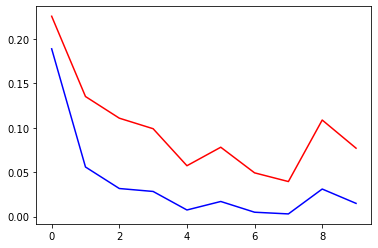

In [148]:
plt.plot(history.history['mae'], 'r')
plt.plot(history.history['mse'], 'b')
plt.show()

In [163]:
history = pred0.evaluate(ds)

12/12 [==============================] - 1s 29ms/step - loss: 0.0404 - mse: 0.0029 - mae: 0.0388


## Anticipatory momentum aware RL trading

Train RL agent $\pi: p \times p \mapsto \{-1, 0, +1\}$ to maximize income (with heavy penalty for loss)

$$\max_{\pi} \dot\$(\pi(p^{<t>}, p^{<t+2>}_{pred}(p^{<t-N:t>}))$$

where $\$(a)$ is the equity after buying or selling

In [161]:
theta_buy = 0.0001
theta_sell = 0.0005

for (seq, nx) in ds:
    preds = pred0(seq)
    for pred in tf.unstack(pred[:, 0]):
        if pred > theta_buy:
            print('buy')
        

In [6]:
order = api.submit_order(
    symbol=symbols[0],
    qty=0.1,
    side='buy',
    type='market',
    time_in_force='day',
)
order

Order({   'asset_class': 'us_equity',
    'asset_id': 'b0b6dd9d-8b9b-48a9-ba46-b9d54906e415',
    'canceled_at': None,
    'client_order_id': 'b341b081-30df-4842-9509-ecc093455186',
    'created_at': '2021-03-26T14:32:01.408634Z',
    'expired_at': None,
    'extended_hours': False,
    'failed_at': None,
    'filled_at': None,
    'filled_avg_price': None,
    'filled_qty': '0',
    'hwm': None,
    'id': '629a2723-5689-4ed6-a483-96f2aa6ae604',
    'legs': None,
    'limit_price': None,
    'notional': None,
    'order_class': '',
    'order_type': 'market',
    'qty': '0.1',
    'replaced_at': None,
    'replaced_by': None,
    'replaces': None,
    'side': 'buy',
    'status': 'accepted',
    'stop_price': None,
    'submitted_at': '2021-03-26T14:32:01.399758Z',
    'symbol': 'AAPL',
    'time_in_force': 'day',
    'trail_percent': None,
    'trail_price': None,
    'type': 'market',
    'updated_at': '2021-03-26T14:32:01.408634Z'})

Train a predictor on prices

In [ ]:
class RNN(keras.Model):
    
    def build(input_shape):
        # [B, T, N_sym, price]
        N_symbols = input_shape[-2]
        
        self.L1a = tfkl.LSTM(N_symbols, return_state=True, return_sequences=True)
        self.L1b = tfkl.MultiHeadAttention(num_heads=8, key_dim=8)
        self.L1cat = tfkl.Concatenate()
        self.L2 = tfkl.LSTM(N_symbols, return_state=True)
        
        self.L3 = tfkl.Dense(2*N_symbols)
        self.L4 = tfpl.DistributionLambda(
            make_distribution_fn=lambda x: tfp.distributions.Normal(
                loc=x[:N_symbols], scale=x[N_symbols:]),
            convert_to_tensor_fn=lambda s: s.sample())
        
    def call(self, inputs):
        
        x0, (prev_state_L1a, prev_state_L2) = inputs
        
        x1a_seq, final_memory_state, final_carry_state = \
            self.L1a(x0, initial_state=prev_state_L1a)
        
        x1b = self.L1b(x0, x0)
        
        x1cat = self.L1cat([x1a_seq, x1b])
        
        x2, final_memory_state, final_carry_state = \
            self.L2(x1, initial_state=prev_state_L2)
        
        